# Hate Speech Classification

###  Built using Convolution network

Steps to classify hate speech

 - Preprocess the text data
 - Convert text to numerical tokens
 - Build and Train ML
 - Test the Model

In [1]:
#!pip install git+ssh://git@github.com/Chaitanyachhibba/preprocess_chaitanyachhibba.git

In [2]:
#!pip install spacy

In [15]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Dropout
from tensorflow.keras.layers import Conv1D, MaxPool1D, GlobalMaxPooling1D, MaxPooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

In [215]:
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import preprocess_chaitanyachhibba as pp
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

## Hate Speech dataset

count = number of CrowdFlower users who coded each tweet (min is 3, sometimes more users coded a tweet when judgments were determined to be unreliable by CF).

hate_speech = number of CF users who judged the tweet to be hate speech.

offensive_language = number of CF users who judged the tweet to be offensive.

neither = number of CF users who judged the tweet to be neither offensive nor non-offensive.

class = class label for majority of CF users. 0 - hate speech 1 - offensive language 2 - neither

In [20]:
df = pd.read_csv('data.csv', index_col = 0)
df.sample(10)

,count,hate_speech,offensive_language,neither,class,tweet
14219,3,0,3,0,1,Pop that pussy
5556,3,1,2,0,1,@_elennamichelle only when ur around me &#1285...
8951,3,0,2,1,1,Detroit nicca but I'm good in the A!!
963,3,0,3,0,1,&#128064; bitches giving back rubs ?
4999,3,0,3,0,1,@Tayscalf @protrill fuck em right in the pussy
8411,3,0,3,0,1,"Britt attitude be for no reason , bitch mad at..."
17686,6,2,4,0,1,"RT @ShesAddicted2Me: ""@187XO_: ' I rather jack..."
24540,6,0,6,0,1,"if dey go to linch together, she gon eat that ..."
14562,3,0,3,0,1,RT @ArtAdame1: Your mcm is a lil bitch
3605,3,2,1,0,0,@InfidelAlie that should read suck on my bacon...


## Text Prepocesing

In [21]:
df['class'].value_counts()

1    19190
2     4163
0     1430
Name: class, dtype: int64

###  - Balance dataset

In [22]:
vc = df['class'].value_counts()
index = list(vc.index)
count = min(vc.values)
index,count

([1, 2, 0], 1430)

In [23]:
df_bal = pd.DataFrame()
for i in index:
  temp = df[df['class']==i].sample(count)
  df_bal = df_bal.append(temp, ignore_index = True)

In [24]:
df_bal['class'].value_counts()

0    1430
1    1430
2    1430
Name: class, dtype: int64

In [25]:
df = df_bal.copy()
df['class'].value_counts()

0    1430
1    1430
2    1430
Name: class, dtype: int64

In [26]:
def get_clean(x):
    x = str(x).lower().replace('\\', '').replace('_', ' ')
    x = pp.cont_exp(x)
    x = pp.remove_emails(x)
    x = pp.remove_urls(x)
    x = pp.remove_html_tags(x)
    x = pp.remove_rt(x)
    x = pp.remove_accented_chars(x)
    x = pp.remove_special_chars(x)
    x = re.sub("(.)\\1{2,}", "\\1", x)
    return x

In [27]:
x = 'iiii llloooooovvvveeee_#@youuuuuuu'
get_clean(x)

'i love you'

In [28]:
x = ' new ch.ch@gmail.com'
get_clean(x)

'new'

In [29]:
df['tweet'] = df['tweet'].apply(lambda x: get_clean(x))

In [30]:
df.sample(10)

,count,hate_speech,offensive_language,neither,class,tweet
2531,3,0,0,3,2,video charlie backer makes final push for votes
46,3,1,2,0,1,i dontkiara done w all these fuck niggas snip ...
361,3,0,3,0,1,bitcheatme like damn bitch yeah its me
2702,3,0,0,3,2,philhecken i dont understand how its weak to g...
466,3,0,3,0,1,i follow sum bush ass bitches on here
2389,3,0,0,3,2,sippey that is where birds came from
1537,3,0,0,3,2,might walk to dunkin donuts i want a oreo coff...
1471,3,0,0,3,2,somexlcan who needs twinkies when you got gans...
2855,3,0,0,3,2,radiotour en duchess of cambridge to present t...
2007,3,0,0,3,2,lastwordevan an inning and a half away from al...


### Text Tokenization

In [31]:
text = df['tweet'].tolist()

In [32]:
len(text)

4290

In [33]:
token = Tokenizer()
token.fit_on_texts(text)

In [34]:
# TEST

t  = Tokenizer()
fit_text = ["The earth is an awesome place live","amazed by awesome earth","new place"]
t.fit_on_texts(fit_text)

test_text = "The earth is an great place live"
sequences = t.texts_to_sequences(test_text)

print("sequences : ",sequences,'\n')

print("word_index : ",t.word_index)
print()
print(t.word_counts)
print()
print(t.index_word)

#print("word_index : ",t.sequences_to_texts([1,2]))

sequences :  [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []] 

word_index :  {'earth': 1, 'awesome': 2, 'place': 3, 'the': 4, 'is': 5, 'an': 6, 'live': 7, 'amazed': 8, 'by': 9, 'new': 10}

OrderedDict([('the', 1), ('earth', 2), ('is', 1), ('an', 1), ('awesome', 2), ('place', 2), ('live', 1), ('amazed', 1), ('by', 1), ('new', 1)])

{1: 'earth', 2: 'awesome', 3: 'place', 4: 'the', 5: 'is', 6: 'an', 7: 'live', 8: 'amazed', 9: 'by', 10: 'new'}


In [35]:
token.word_counts

OrderedDict([('jusdontblowmyhi', 1),
             ('yall', 103),
             ('lucky', 6),
             ('dmx', 2),
             ('stopped', 4),
             ('makin', 3),
             ('music', 27),
             ('i', 1505),
             ('would', 112),
             ('still', 85),
             ('be', 353),
             ('barking', 1),
             ('at', 216),
             ('these', 154),
             ('hoes', 237),
             ('foo', 1),
             ('kep0ne', 1),
             ('quanb24', 2),
             ('you', 1238),
             ('bitch', 797),
             ('ass', 284),
             ('nigga', 219),
             ('tanning', 2),
             ('with', 306),
             ('my', 549),
             ('main', 8),
             ('should', 60),
             ('have', 248),
             ('fought', 1),
             ('when', 194),
             ('was', 212),
             ('over', 51),
             ('there', 92),
             ('if', 238),
             ('only', 71),
             ('myself', 11

In [36]:
token.index_word

{1: 'a',
 2: 'i',
 3: 'the',
 4: 'you',
 5: 'to',
 6: 'is',
 7: 'bitch',
 8: 'and',
 9: 'not',
 10: 'that',
 11: 'in',
 12: 'my',
 13: 'of',
 14: 'it',
 15: 'like',
 16: 'on',
 17: 'me',
 18: 'am',
 19: 'for',
 20: 'do',
 21: 'trash',
 22: 'this',
 23: 'your',
 24: 'be',
 25: 'are',
 26: 'with',
 27: 'ass',
 28: 'bitches',
 29: 'they',
 30: 'all',
 31: 'so',
 32: 'have',
 33: 'but',
 34: 'if',
 35: 'hoes',
 36: 'just',
 37: 'up',
 38: 'fuck',
 39: 'nigga',
 40: 'pussy',
 41: 'he',
 42: 'at',
 43: 'was',
 44: 'faggot',
 45: 'get',
 46: 'no',
 47: 'when',
 48: 'hoe',
 49: 'out',
 50: 'white',
 51: 'what',
 52: 'got',
 53: 'these',
 54: 'can',
 55: 'shit',
 56: 'lol',
 57: 'about',
 58: 'will',
 59: 'fucking',
 60: 'she',
 61: 'some',
 62: 'youre',
 63: 'know',
 64: 'them',
 65: 'from',
 66: 'how',
 67: 'we',
 68: 'his',
 69: 'nigger',
 70: 'as',
 71: 'who',
 72: 'niggas',
 73: 'would',
 74: 'her',
 75: 'one',
 76: 'or',
 77: 'go',
 78: 'people',
 79: 'yall',
 80: 'an',
 81: 'man',
 82: '

In [37]:
x = ["who hates you"]

In [38]:
token.texts_to_sequences(x)

[[71, 1064, 4]]

In [39]:
[token.index_word[i] for i in token.texts_to_sequences(x)[0]]    

['who', 'hates', 'you']

In [40]:
vocab_size = len(token.word_counts) + 1
vocab_size

11880

In [41]:
encoded_text = token.texts_to_sequences(text)
encoded_text

[[3836, 79, 948, 2312, 1327, 1704, 265, 2, 73, 94, 24, 3837, 42, 53, 35, 3838],
 [3839, 2313, 4, 7, 27, 39],
 [2314, 26, 12, 746, 7],
 [2,
  131,
  32,
  3840,
  4,
  47,
  2,
  43,
  151,
  87,
  34,
  110,
  2,
  43,
  566,
  8,
  2,
  32,
  9,
  1328,
  10,
  185,
  57,
  4,
  110,
  133,
  206,
  1096,
  7,
  255],
 [22, 7, 1097, 166, 747],
 [949, 27, 35],
 [3841, 748, 40, 6, 3, 207, 40],
 [950,
  3842,
  1705,
  831,
  832,
  168,
  3,
  3843,
  430,
  4,
  147,
  103,
  41,
  118,
  9,
  63,
  47,
  5,
  193,
  115,
  662],
 [3844, 66, 190, 64, 951, 3845, 40],
 [3846, 40],
 [2, 20, 9, 3847, 22, 55, 33, 7, 2, 18, 51, 2, 18, 8, 14, 6, 51, 14, 6],
 [3848,
  148,
  156,
  275,
  14,
  168,
  314,
  482,
  148,
  3849,
  127,
  1,
  3850,
  315,
  15,
  1,
  2315,
  194,
  40,
  195,
  459,
  14,
  80,
  14,
  58,
  24,
  288],
 [40, 16, 12, 611, 40, 16, 12, 3851, 952],
 [12, 663, 25, 3852, 10, 6, 9, 510, 111, 29, 25, 2316, 460, 12, 1329],
 [140,
  749,
  2317,
  20,
  9,
  1706,
  17

In [42]:
encoded_text[0]

[3836, 79, 948, 2312, 1327, 1704, 265, 2, 73, 94, 24, 3837, 42, 53, 35, 3838]

In [43]:
lt = [token.index_word[i] for i in encoded_text[0]]
print(" ".join(lt))

jusdontblowmyhi yall lucky dmx stopped makin music i would still be barking at these hoes foo


In [44]:
text[0]

'jusdontblowmyhi yall lucky dmx stopped makin music i would still be barking at these hoes foo'

In [45]:
# FIND MAX LENGTH
x=0
cnt=0 
max_length_counter=0 
for i in encoded_text:
    if len(i) > x:
        x = len(i)
        max_length_counter = cnt
    cnt+=1
print(f'max lenght -> {x} at loc -> {max_length_counter}')
print(f'{text[max_length_counter]}')

max lenght -> 34 at loc -> 642
i would shut the fuck up or i will just be wide and batter any boy you ever go out with haha im a cunt so wit you cani do shit to stop me


In [46]:
max_length = 120
X = pad_sequences(encoded_text, maxlen=max_length, padding = 'post')

In [47]:
X

array([[ 3836,    79,   948, ...,     0,     0,     0],
       [ 3839,  2313,     4, ...,     0,     0,     0],
       [ 2314,    26,    12, ...,     0,     0,     0],
       ...,
       [   10, 11872,    13, ...,     0,     0,     0],
       [   38,  1846,   647, ...,     0,     0,     0],
       [11874, 11875,  3766, ...,     0,     0,     0]])

In [48]:
X.shape

(4290, 120)

## MODEL

In [49]:
y = df['class']

In [50]:
y

0       1
1       1
2       1
3       1
4       1
       ..
4285    0
4286    0
4287    0
4288    0
4289    0
Name: class, Length: 4290, dtype: int64

In [51]:
y = to_categorical(df['class'])
y

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

In [52]:
y.shape

(4290, 3)

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)

In [54]:
X_train.shape, X_test.shape,y_train.shape, y_test.shape

((3432, 120), (858, 120), (3432, 3), (858, 3))

In [188]:
vec_size = 300
model = Sequential()
model.add(Embedding(vocab_size, vec_size, input_length=max_length))

model.add(Conv1D(32, 2, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
#model.add(GlobalMaxPooling1D())
model.add(Dense(3, activation='softmax'))

In [190]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 120, 300)          3564000   
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 119, 32)           19232     
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 23, 32)            0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 23, 32)            0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 736)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 32)                23584     
_________________________________________________________________
dropout_22 (Dropout)         (None, 32)              

In [191]:
model.compile(optimizer=Adam(learning_rate=0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [192]:
#Check GPUs
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [193]:
model.fit(X_train, y_train, epochs = 5, validation_data=(X_test, y_test), shuffle = True)

Train on 3432 samples, validate on 858 samples
Epoch 1/5
3432/3432 [==============================] - 4s 1ms/sample - loss: 1.0602 - accuracy: 0.4414 - val_loss: 0.8295 - val_accuracy: 0.7145
Epoch 2/5
3432/3432 [==============================] - 3s 907us/sample - loss: 0.5748 - accuracy: 0.7829 - val_loss: 0.5320 - val_accuracy: 0.7972
Epoch 3/5
3432/3432 [==============================] - 3s 895us/sample - loss: 0.2565 - accuracy: 0.9100 - val_loss: 0.5567 - val_accuracy: 0.7809
Epoch 4/5
3432/3432 [==============================] - 3s 898us/sample - loss: 0.1147 - accuracy: 0.9650 - val_loss: 0.6547 - val_accuracy: 0.7506
Epoch 5/5
3432/3432 [==============================] - 3s 900us/sample - loss: 0.0495 - accuracy: 0.9875 - val_loss: 0.7624 - val_accuracy: 0.7587


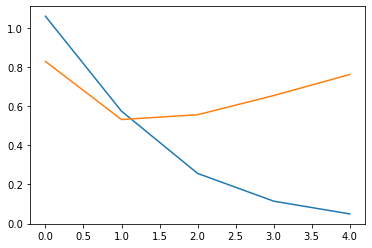

In [194]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])

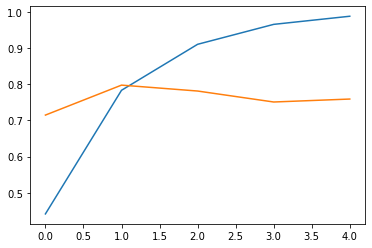

In [195]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])

### Model Testing

In [196]:
y_pred = np.argmax(model.predict(X_test), axis=-1)

In [197]:
y_pred[0:15]

array([2, 2, 2, 0, 2, 1, 2, 1, 0, 1, 0, 2, 0, 0, 1], dtype=int64)

In [198]:
y_test_real = np.argmax(y_test, axis=-1)  

In [199]:
y_test_real[0:15]

array([2, 2, 2, 2, 2, 0, 2, 1, 0, 1, 1, 2, 0, 0, 0], dtype=int64)

In [200]:
print(confusion_matrix(y_test_real,y_pred))

[[180  70  36]
 [ 51 218  17]
 [ 12  21 253]]


<AxesSubplot:>

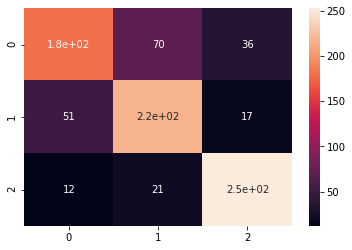

In [201]:
sns.heatmap(confusion_matrix(y_test_real,y_pred),annot= True)

In [202]:
print(classification_report(y_test_real,y_pred))

              precision    recall  f1-score   support

           0       0.74      0.63      0.68       286
           1       0.71      0.76      0.73       286
           2       0.83      0.88      0.85       286

    accuracy                           0.76       858
   macro avg       0.76      0.76      0.76       858
weighted avg       0.76      0.76      0.76       858



(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

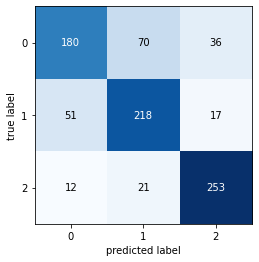

In [203]:
plot_confusion_matrix(confusion_matrix(y_test_real,y_pred))

### Testing with Custom Data

In [204]:
def get_encoded(x):
  x = get_clean(x)
  x = token.texts_to_sequences([x])
  x = pad_sequences(x, maxlen=max_length, padding = 'post')
  return x

In [205]:
x = 'hey bitch whass up'
sample_data =  get_encoded(x)
sample_data

array([[293,   7,  37,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0]])

In [206]:
model.predict_classes(sample_data)

array([1], dtype=int64)

In [207]:
np.argmax(model.predict(sample_data), axis=-1)

array([1], dtype=int64)

In [208]:
x = 'How is it going'
sample_data =  get_encoded(x)
np.argmax(model.predict(sample_data), axis=-1)

array([2], dtype=int64)

In [209]:
x = 'you are horrible man'
sample_data =  get_encoded(x)
np.argmax(model.predict(sample_data), axis=-1)

array([0], dtype=int64)

In [216]:
model.save('model_hate_speech.h5')

In [217]:
pickle.dump(token, open('token.pkl', 'wb'))

In [210]:
x = np.array([[4,2,3], [1,0,5]])
x

array([[4, 2, 3],
       [1, 0, 5]])

In [211]:
np.argmax(x)

5

In [212]:
np.argmax(x, axis = 0)

array([0, 0, 1], dtype=int64)

In [213]:
np.argmax(x, axis = 1)

array([0, 2], dtype=int64)

In [214]:
np.argmax(x, axis = -1)

array([0, 2], dtype=int64)